## Lab Work 3: Regularization

This notebook builds on the third lecture of Foundations of Machine Learning. We'll focus on the regularization.

Important note: the steps shown here are not always the most efficient or the most "industry-approved." Their main purpose is pedagogical. So don't panic if something looks suboptimal—it's meant to be.

If you have questions (theoretical or practical), don't hesitate to bug your lecturer.


First the necessary imports:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


### 1. Generate a synthetic dataset

For this lecture it is better to use a **synthetic dataset**. Don't worry, we will have fun with real data another time together!

- Create a dataset with informative, redundant, and noisy features.
- Create a dataset with informative, redundant, and noisy features.
- Define true coefficients for the informative features.
- Add Gaussian noise to the target.
- Split the data into training and test sets.

In [2]:
# --------------------------
# 1. Synthetic dataset
# --------------------------
n_samples = 200
n_informative = 5
n_redundant = 50
n_noise = 100
n_features = n_informative + n_redundant + n_noise
noise_std = 5.0

# True coefficients: first 5 informative
true_coefs = np.zeros(n_features)
true_coefs[:n_informative] = [10, 8, 6, 4, 2]

# Informative features
X_informative = np.random.randn(n_samples, n_informative)

# Redundant features (correlated)
X_redundant = np.zeros((n_samples, n_redundant))
for i in range(n_redundant):
    X_redundant[:, i] = X_informative[:, i % n_informative] + 0.1 * np.random.randn(n_samples)

# Noise features
X_noise = np.random.randn(n_samples, n_noise)

# Combine features
X = np.hstack([X_informative, X_redundant, X_noise])

# Target with noise
y = X @ true_coefs + np.random.randn(n_samples) * noise_std

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 2. Standardize the features
- Use `StandardScaler` to scale the training and test features.
- Comment: why is scaling important for regularized linear models?

In [3]:
# --------------------------
# 1b. Standardize features
# --------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 3. Fit linear models
Fit the following models on the scaled training set:
- Ordinary Least Squares (OLS)
- Ridge Regression
- Lasso Regression -> why do I need max_iter?
- Elastic Net 
- Predict on the test set.

In [4]:
# --------------------------
# 2. Fit models (scaled)
# --------------------------
ols = LinearRegression()
ridge = Ridge(alpha=1) #analytic solution -> matrices
lasso = Lasso(alpha=1, max_iter=10000) #soft-thresholding
elastic = ElasticNet(alpha=0.5, l1_ratio=0.5, max_iter=10000)

ols.fit(X_train_scaled, y_train)
ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)
elastic.fit(X_train_scaled, y_train)

y_pred_ols = ols.predict(X_test_scaled)
y_pred_ridge = ridge.predict(X_test_scaled)
y_pred_lasso = lasso.predict(X_test_scaled)
y_pred_enet = elastic.predict(X_test_scaled)


### 4. Compute performance metrics
- Compute RMSE and R² for each model on the test set.
- Compare the performance of OLS vs regularized models.



For true values $y_i$ and predicted values $\hat{y}_i$:

$$
R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}
$$

where $\bar{y}$ is the mean of the true values.

In [5]:
# --------------------------
# 4. Metrics
# --------------------------
def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'R2': r2}

print("OLS Metrics:", metrics(y_test, y_pred_ols))
print("Ridge Metrics:", metrics(y_test, y_pred_ridge))
print("Lasso Metrics:", metrics(y_test, y_pred_lasso))
print("Elastic Net Metrics:", metrics(y_test, y_pred_enet))

OLS Metrics: {'RMSE': np.float64(14.977810171761856), 'R2': 0.2414542941769442}
Ridge Metrics: {'RMSE': np.float64(10.128282947520086), 'R2': 0.6531379704216256}
Lasso Metrics: {'RMSE': np.float64(6.130494091590528), 'R2': 0.8729203334966509}
Elastic Net Metrics: {'RMSE': np.float64(6.438190880302073), 'R2': 0.8598436408949621}


### 5. Multiple runs to show prediction instability

Add small Gaussian noise to the training set and refit each model multiple times. Plot predictions against true values to see which methods are stable.

OLS mean R2: 0.23198690723570778 std R2: 0.15645633650826204
Ridge mean R2: 0.6557277243999062 std R2: 0.014141530206730858
Lasso mean R2: 0.8710659440315508 std R2: 0.0023848335730898
Elastic mean R2: 0.8600160964850339 std R2: 0.0011624353027956504


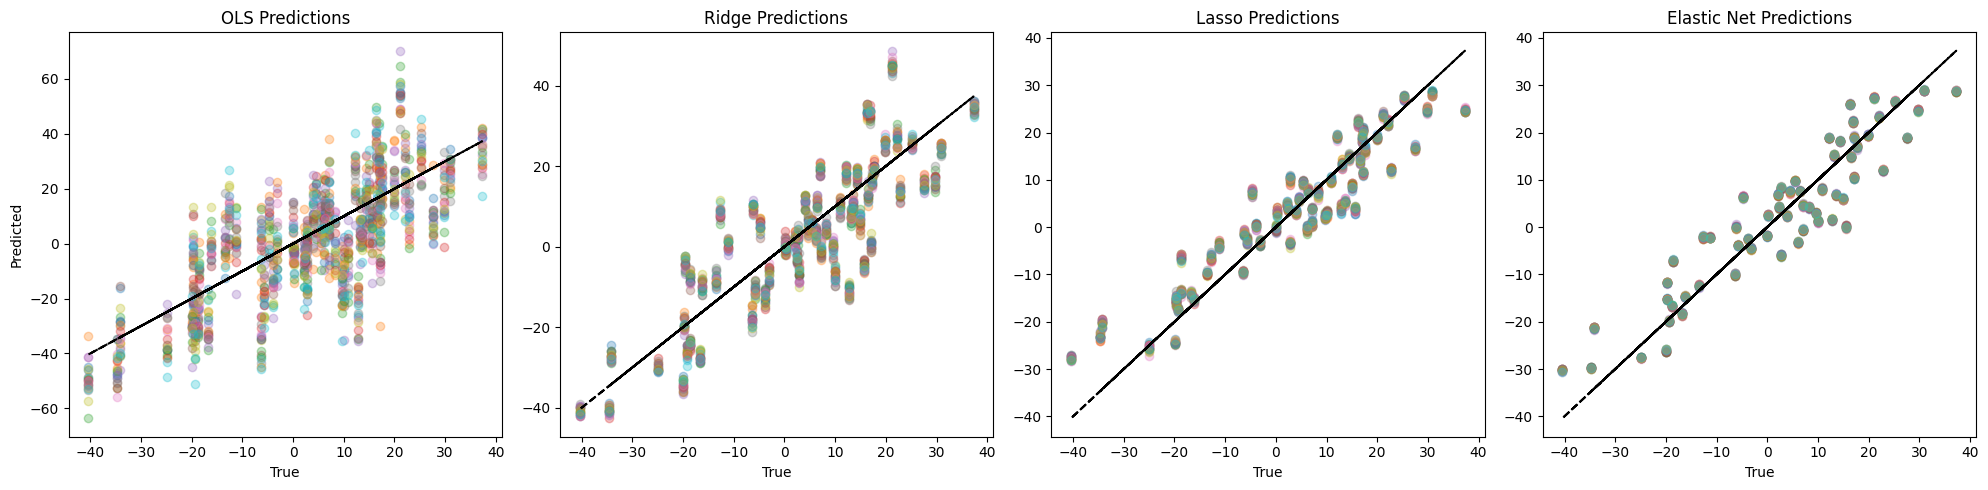

In [6]:
# --------------------------
# 5. Multiple runs to show instability
# --------------------------
n_runs = 20
preds_ols, preds_ridge, preds_lasso, preds_enet = [], [], [], []

for run in range(n_runs):
    X_train_noisy = X_train_scaled + 0.05 * np.random.randn(*X_train_scaled.shape)
    
    ols.fit(X_train_noisy, y_train)
    ridge.fit(X_train_noisy, y_train)
    lasso.fit(X_train_noisy, y_train)
    elastic.fit(X_train_noisy, y_train)
    
    preds_ols.append(ols.predict(X_test_scaled))
    preds_ridge.append(ridge.predict(X_test_scaled))
    preds_lasso.append(lasso.predict(X_test_scaled))
    preds_enet.append(elastic.predict(X_test_scaled))

preds_ols = np.array(preds_ols)
preds_ridge = np.array(preds_ridge)
preds_lasso = np.array(preds_lasso)
preds_enet = np.array(preds_enet)

for name, preds in zip(["OLS","Ridge","Lasso","Elastic"],
                       [preds_ols, preds_ridge, preds_lasso, preds_enet]):
    r2s = [r2_score(y_test, p) for p in preds]
    print(name, "mean R2:", np.mean(r2s), "std R2:", np.std(r2s))


plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
for i in range(n_runs):
    plt.plot(y_test, preds_ols[i], 'o', alpha=0.3)
plt.plot(y_test, y_test, 'k--')
plt.title('OLS Predictions')
plt.xlabel('True')
plt.ylabel('Predicted')

plt.subplot(1,4,2)
for i in range(n_runs):
    plt.plot(y_test, preds_ridge[i], 'o', alpha=0.3)
plt.plot(y_test, y_test, 'k--')
plt.title('Ridge Predictions')
plt.xlabel('True')

plt.subplot(1,4,3)
for i in range(n_runs):
    plt.plot(y_test, preds_lasso[i], 'o', alpha=0.3)
plt.plot(y_test, y_test, 'k--')
plt.title('Lasso Predictions')
plt.xlabel('True')

plt.subplot(1,4,4)
for i in range(n_runs):
    plt.plot(y_test, preds_enet[i], 'o', alpha=0.3)
plt.plot(y_test, y_test, 'k--')
plt.title('Elastic Net Predictions')
plt.xlabel('True')

plt.tight_layout()
plt.show()

### 6. Compare coefficients

Plot coefficients of all four models. Observe how Lasso and Elastic Net shrink some coefficients to zero while Ridge shrinks them continuously.

OLS first 10 coefs: [ 2.56  7.87 -0.1   3.2  17.13  0.12 -5.99  0.33 -5.17  6.75]


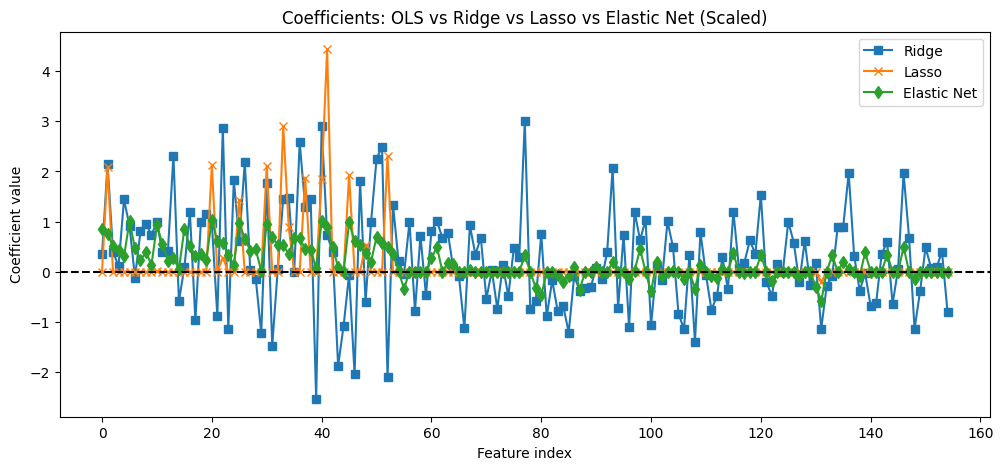

In [7]:
# --------------------------
# 6. Coefficient comparison
# --------------------------
plt.figure(figsize=(12,5))
print("OLS first 10 coefs:", np.round(ols.coef_[:10], 2))
#plt.plot(ols.coef_, 'o-', label='OLS')
plt.plot(ridge.coef_, 's-', label='Ridge')
plt.plot(lasso.coef_, 'x-', label='Lasso')
plt.plot(elastic.coef_, 'd-', label='Elastic Net')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Feature index")
plt.ylabel("Coefficient value")
plt.title("Coefficients: OLS vs Ridge vs Lasso vs Elastic Net (Scaled)")
plt.legend()
plt.show()

### 6. Coefficient paths

Vary the regularization strength (`alpha`) and plot the coefficient paths for Ridge, Lasso, and Elastic Net.

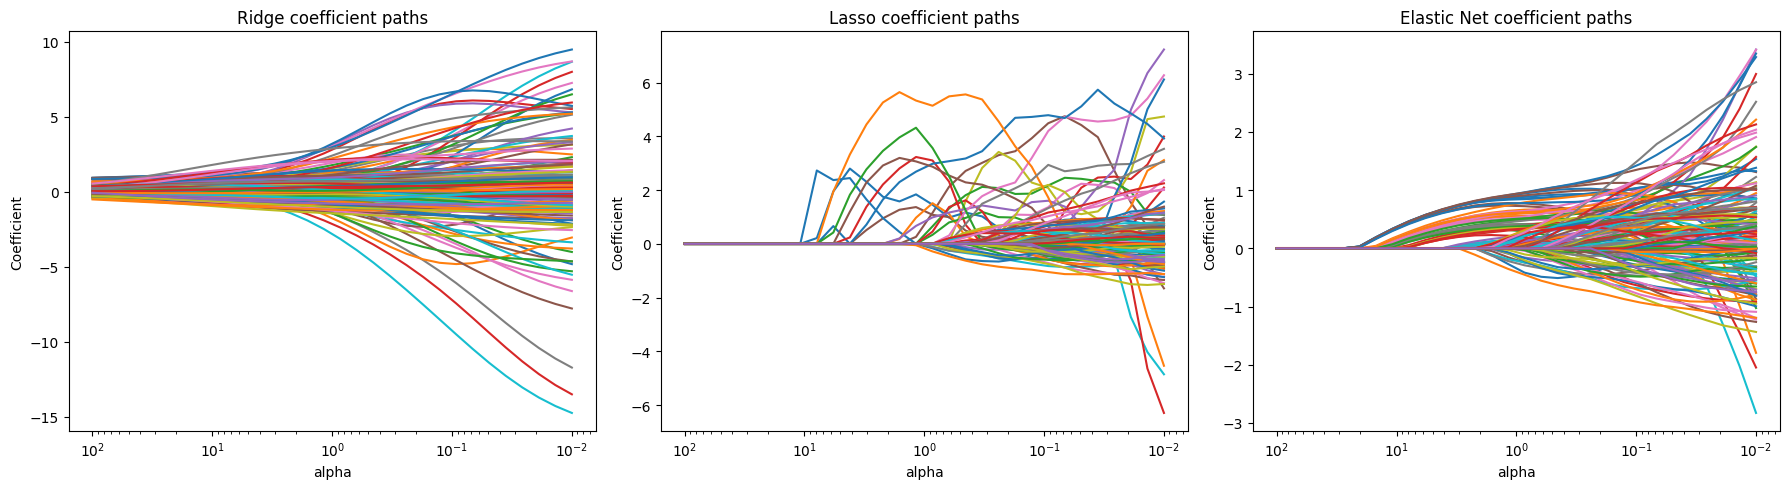

In [8]:
# --------------------------
# 8. Coefficient paths
# --------------------------
alphas_ridge = np.logspace(-2, 2, 30)
alphas_lasso = np.logspace(-2, 2, 30)
alphas_enet = np.logspace(-2, 2, 30)

coefs_ridge, coefs_lasso, coefs_enet = [], [], []

for a in alphas_ridge:
    coefs_ridge.append(Ridge(alpha=a).fit(X_train_scaled, y_train).coef_)
for a in alphas_lasso:
    coefs_lasso.append(Lasso(alpha=a, max_iter=10000).fit(X_train_scaled, y_train).coef_)
for a in alphas_enet:
    coefs_enet.append(ElasticNet(alpha=a, l1_ratio=0.5, max_iter=10000).fit(X_train_scaled, y_train).coef_)

coefs_ridge = np.array(coefs_ridge)
coefs_lasso = np.array(coefs_lasso)
coefs_enet = np.array(coefs_enet)

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
for i in range(n_features):
    plt.plot(alphas_ridge, coefs_ridge[:,i])
plt.xscale('log')
plt.title('Ridge coefficient paths')
plt.xlabel('alpha')
plt.ylabel('Coefficient')
plt.gca().invert_xaxis()

plt.subplot(1,3,2)
for i in range(n_features):
    plt.plot(alphas_lasso, coefs_lasso[:,i])
plt.xscale('log')
plt.title('Lasso coefficient paths')
plt.xlabel('alpha')
plt.ylabel('Coefficient')
plt.gca().invert_xaxis()

plt.subplot(1,3,3)
for i in range(n_features):
    plt.plot(alphas_enet, coefs_enet[:,i])
plt.xscale('log')
plt.title('Elastic Net coefficient paths')
plt.xlabel('alpha')
plt.ylabel('Coefficient')
plt.gca().invert_xaxis()

plt.tight_layout()
plt.show()

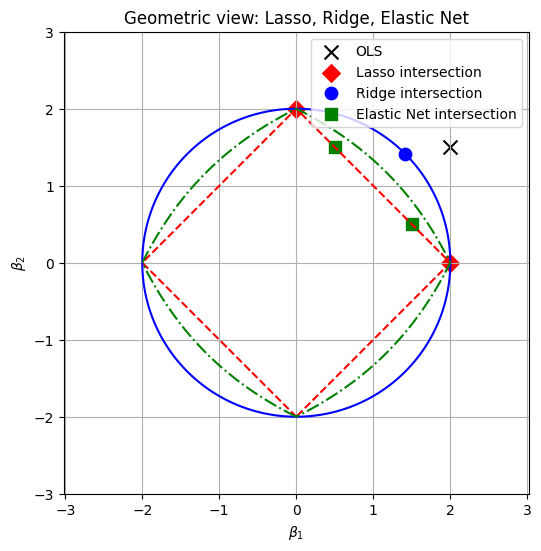

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Grid of beta values
beta1 = np.linspace(-3, 3, 400)
beta2 = np.linspace(-3, 3, 400)
B1, B2 = np.meshgrid(beta1, beta2)

# Constraints
l1_constraint = np.abs(B1) + np.abs(B2)           # Lasso
l2_constraint = np.sqrt(B1**2 + B2**2)           # Ridge
l1_ratio = 0.5                                   # Elastic Net mixing
enet_constraint = l1_ratio*(np.abs(B1)+np.abs(B2)) + (1-l1_ratio)*np.sqrt(B1**2 + B2**2)

# Example OLS solution
beta_ols = np.array([2.0, 1.5])

plt.figure(figsize=(6,6))

# Draw L1 diamond
plt.contour(B1, B2, l1_constraint, levels=[2], colors='red', linestyles='--')
# Draw L2 circle
plt.contour(B1, B2, l2_constraint, levels=[2], colors='blue', linestyles='-')
# Draw Elastic Net "rounded diamond"
plt.contour(B1, B2, enet_constraint, levels=[2], colors='green', linestyles='-.')

# Plot OLS solution
plt.scatter(beta_ols[0], beta_ols[1], color='black', marker='x', s=100, label='OLS')

# Illustrative intersections
plt.scatter([2, 0], [0, 2], color='red', marker='D', s=80, label='Lasso intersection')
plt.scatter([1.41], [1.41], color='blue', marker='o', s=80, label='Ridge intersection')
plt.scatter([1.5, 0.5], [0.5, 1.5], color='green', marker='s', s=80, label='Elastic Net intersection')

plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_2$')
plt.title('Geometric view: Lasso, Ridge, Elastic Net')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()